# Fires of Interest

In [1]:
%matplotlib inline

import numpy as np
from datetime import date, datetime, timedelta

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

## Dictionary of Fires of Interest

In [2]:
FIRES = {'PIONEER':{'lat': 43.950,
                    'lon': -115.762,
                    'start': datetime(2016, 7, 18),
                    'state': 'Idaho'},         
         'BRIANHEAD':{'lat': 37.718,
                      'lon': -112.837,
                      'start': datetime(2017, 6, 17),
                      'state': 'Utah'},
         'SOUTHERN LNU COMPLEX':{'lat': 38.296,
                                 'lon': -122.275,
                                 'start': datetime(2017, 10, 9),
                                 'state': 'California'},
         'CENTRAL LNU COMPLEX':{'lat': 38.433,
                                'lon': -122.703,
                                'start': datetime(2017, 10, 9),
                                'state': 'California'},
         'THOMAS':{'lat': 34.429,
                   'lon': -119.100,
                   'start': datetime(2017, 12, 5),
                   'satet': 'California'},
         'CREEK':{'lat': 34.334,
                  'lon': -118.338,
                  'start': datetime(2017, 12, 5),
                  'state': 'California'},
         'RYE':{'lat': 34.453,
                'lon': -118.581,
                'start': datetime(2017, 12, 5),
                'state': 'California'},
         'Rhea'{'lat':35.849,
                'lon':-99.213,
                'start': datetime(2018, 4, 12),
                'end': datetime(2018, 4, 28),
                'state':'Oklahoma'        
               }
         'Mallard':{'lat': 34.810,
                    'lon': -101.306,
                    'start': datetime(2018, 5, 8),
                    'end': datetime(2018, 5, 21)
                    'state': 'Texas'},
         }

## Plot Fire Locations on a Map

In [3]:
lats = [FIRES[F]['lat'] for F in FIRES.keys()]
lons = [FIRES[F]['lon'] for F in FIRES.keys()]

bot_left_lat  = min(lats)-1.5
bot_left_lon  = min(lons)-1.5
top_right_lat = max(lats)+1.5
top_right_lon = max(lons)+1.5

m = Basemap(resolution='i', projection='cyl', area_thresh=1500,\
        llcrnrlon=bot_left_lon, llcrnrlat=bot_left_lat, \
        urcrnrlon=top_right_lon, urcrnrlat=top_right_lat)

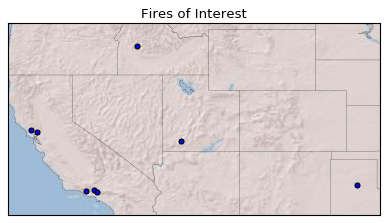

In [4]:
m.arcgisimage(service='World_Shaded_Relief', dpi=1000)
m.drawstates(linewidth=.1)
m.drawcoastlines(linewidth=.15)
m.drawcountries(linewidth=.1)
#m.drawcounties()

plt.title('Fires of Interest')

for F in FIRES.keys():
    m.scatter(FIRES[F]['lon'], FIRES[F]['lat'])

-----

## Plot Fire Boundary via Shapefile
Consult these docs before you get started: http://basemaptutorial.readthedocs.io/en/latest/shapefile.html

### Read in the shape file
This takes some time if there are lots of shapes
 - `ms.` is the map for the full shape file
 - `mf.` is the map for the specific fire

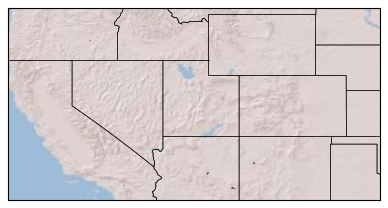

In [15]:
# Need a map object to read in shapefile.
# As long as you stay in the default projection, this should work.
# Note: ArcGIS base image wont work in lcc projection.

# Yearly Fire
#shapefile = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/perimeters_dd83'

# Daily Fire
shapefile = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/active_perimeters_dd83'

m.arcgisimage(service='World_Shaded_Relief', dpi=1000)
m.drawstates()
per = m.readshapefile(shapefile, 'perim',
                      linewidth=.5,
                      color='dimgrey',
                      drawbounds=True)

In [10]:
#ms.perim_info

### Print List of each fire

In [16]:
fires = []
for info, PERIM in zip(ms.perim_info, ms.perim):
    fires.append(info['FIRENAME'])
a = np.unique(fires)
for i in a:
    print i

BUZZARD
Blue Water
CARACARA
Curlew
FLAMINGO
McDannald
OK Bar
Rattlesnake
Tinder
Tye River
VULTURE
Voltage


### Center the Fire on a Map

In [ ]:
# Specify a fire name. 
# Must be in the list above, becuase we need the start lat/lon to build the map.
firename = ['POCKET', 'TUBBS', 'NUNS']

# Find the average lat/lon for the fire. This will be the center.
mean_lats = np.array([])
mean_lons = np.array([])
for info, PERIM in zip(ms.perim_info, ms.perim):
    # Check if the boundary is one of the large active fires
    if info['FIRENAME'].upper() in firename:
        mean_lats = np.append(mean_lats, np.mean(np.array(PERIM)[:,1]))
        mean_lons = np.append(mean_lons, np.mean(np.array(PERIM)[:,0]))

mean_lat = np.mean(mean_lats)
mean_lon = np.mean(mean_lons)

# Create a new map for this fire
bot_left_lat  = mean_lat-.5
bot_left_lon  = mean_lon-.5
top_right_lat = mean_lat+.5
top_right_lon = mean_lon+.5

mf = Basemap(resolution='i', projection='cyl', area_thresh=1500,\
        llcrnrlon=bot_left_lon, llcrnrlat=bot_left_lat, \
        urcrnrlon=top_right_lon, urcrnrlat=top_right_lat)

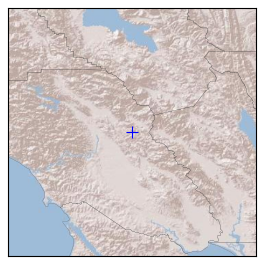

In [10]:
# Make a preview map
mf.drawstates()
mf.drawcounties()
mf.drawcountries()
mf.arcgisimage(service='World_Shaded_Relief', dpi=1000)
mf.scatter(mean_lon, mean_lat, marker='+', s=100)

### Filling Fire Perimeter
It is straightforward to plot the boundary on a map by the latitude and longitude. You can do this with `plt.plot` or `plt.scatter`. However, if you want to fill the fire perimeter with a color, you must create a polygon object.

##### Fire Perimeter by Latest Drawn Image

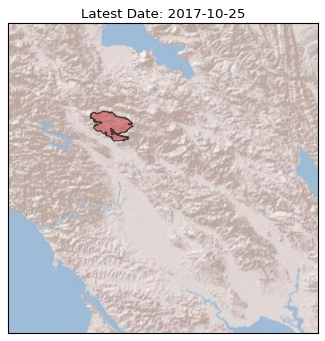

In [11]:
plt.figure(1, figsize=[5, 5])

# Shape by Fire Name and Last Date
recent_date = date(2010, 1, 1)

for i, [info, PERIM] in enumerate(zip(ms.perim_info, ms.perim)):
    # Check if the boundary is one of the large active fires
    if info['FIRENAME'].upper() in firename:
        f = info['PERDATTIME']
        draw_date = date(f[0], f[1], f[2])
        if draw_date > recent_date:
            patches = []
            recent_date = draw_date
            patches.append(Polygon(np.array(PERIM), True) )

plt.gca().add_collection(PatchCollection(patches,
                         facecolor='indianred',
                         alpha=.65,
                         edgecolor='k',
                         linewidths=1,
                         zorder=1))

plt.title('Latest Date: %s' % recent_date)
mf.arcgisimage(service='World_Shaded_Relief', dpi=1000)

##### Fire Perimeter by Largest Area

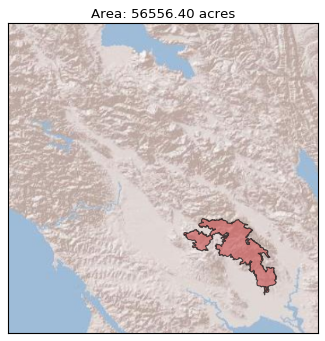

In [12]:
plt.figure(1, figsize=[5, 5])

# Shape by Fire Name and Largest Area
area = 0

for i, [info, PERIM] in enumerate(zip(ms.perim_info, ms.perim)):
    # Check if the boundary is one of the large active fires
    if info['FIRENAME'].upper() in firename:
        f = info['GISACRES']
        draw_area = float(f)
        if draw_area > area:
            patches = []
            area = draw_area
            patches.append(Polygon(np.array(PERIM), True) )

plt.gca().add_collection(PatchCollection(patches,
                         facecolor='indianred',
                         alpha=.65,
                         edgecolor='k',
                         linewidths=1,
                         zorder=1))

plt.title('Area: %.2f acres' % area)
mf.arcgisimage(service='World_Shaded_Relief', dpi=1000)

##### All shapes for the Fire Name

In [54]:
# Create a new map for this fire
bot_left_lat  = mean_lat-5.75
bot_left_lon  = mean_lon-5.75
top_right_lat = mean_lat+5.75
top_right_lon = mean_lon+5.75

mf = Basemap(resolution='i', projection='cyl', area_thresh=1500,\
        llcrnrlon=bot_left_lon, llcrnrlat=bot_left_lat, \
        urcrnrlon=top_right_lon, urcrnrlat=top_right_lat)

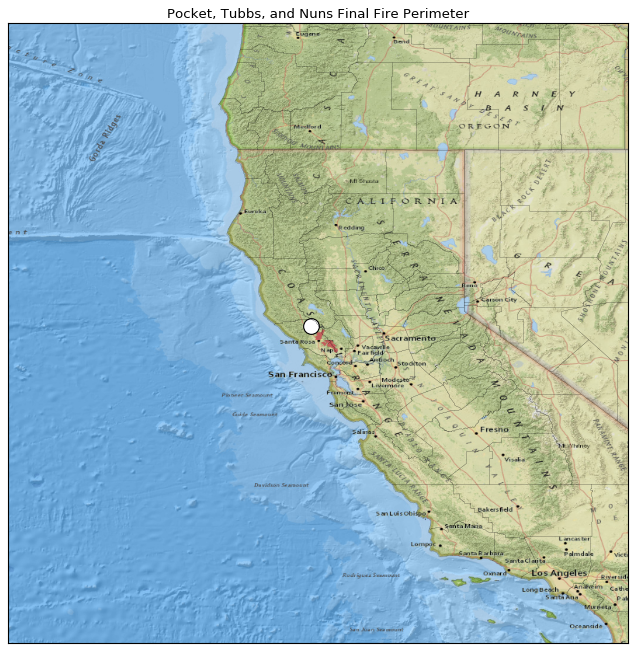

In [55]:
plt.figure(1, figsize=[12, 10])
patches = []
for info, PERIM in zip(ms.perim_info, ms.perim):
    # Check if the boundary is one of the large active fires
    if info['FIRENAME'].upper() in firename:
        patches.append(Polygon(np.array(PERIM), True) )

plt.gca().add_collection(PatchCollection(patches[:],
                         facecolor='indianred',
                         alpha=.1,
                         edgecolor='k',
                         linewidths=0,
                         zorder=1))

plt.title('Pocket, Tubbs, and Nuns Final Fire Perimeter')
#mf.arcgisimage(service='World_Shaded_Relief', dpi=1000)
mf.arcgisimage(service='NatGeo_World_Map', xpixels=800)

# plot station site
plt.scatter(-122.837058, 38.735086, s=200, color='white', edgecolor='k')
m.drawcounties()
plt.savefig('POCKET-TUBBS-NUNS', dpi=300, bbox_inches='tight')

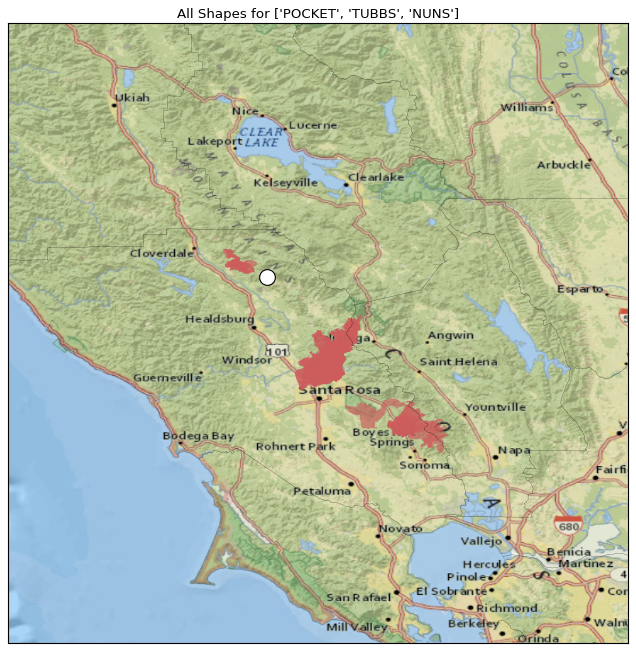

In [52]:
# Fire perimeter up to a certain date...
plt.figure(1, figsize=[12, 10])
patches = []

# Shape by Fire Name and Last Date
recent_date = date(2017, 10, 11)

for i, [info, PERIM] in enumerate(zip(ms.perim_info, ms.perim)):
    # Check if the boundary is one of the large active fires
    if info['FIRENAME'].upper() in firename:
        f = info['PERDATTIME']
        draw_date = date(f[0], f[1], f[2])
        if draw_date <= recent_date:
            patches.append(Polygon(np.array(PERIM), True) )
        
plt.gca().add_collection(PatchCollection(patches[:],
                         facecolor='indianred',
                         alpha=.65,
                         edgecolor='k',
                         linewidths=0,
                         zorder=1))

plt.title('All Shapes for %s' % firename)
#mf.arcgisimage(service='World_Shaded_Relief', dpi=1000)
mf.arcgisimage(service='NatGeo_World_Map', xpixels=800)

# plot station site
plt.scatter(-122.837058, 38.735086, s=200, color='white', edgecolor='k')
m.drawcounties()
plt.savefig('POCKET-TUBBS-NUNS', dpi=300, bbox_inches='tight')

In [36]:
print mean_lon, mean_lat

-122.714322306 38.6002689937


In [13]:
info

{'ACTIVE': 'Y',
 'AGENCY': 'DVF',
 'COMMENTS': '                                                                                                                                                                                                                                                              ',
 'COMPFIRECD': '    ',
 'COMPLEXNM': '                                                                                                    ',
 'COMPPARID': '                                                  ',
 'DATECRNT': [2017, 12, 18],
 'FIRECODE': 'LJJ1',
 'FIRENAME': 'Legion Lake',
 'FIRENUM': '170967',
 'FIREYEAR': '2017',
 'GISACRES': '5.40230188354e+004',
 'INCIDENTID': '2017-SDSDS-170967',
 'INCIWEBID': '          ',
 'INCOMPLEX': 'N',
 'IRWINID': '{E4A0CCED-FFB0-46B5-B6B9-C9E7A4A25487}',
 'MAPMETHOD': 'Mixed Methods',
 'MERGEID': '{}',
 'PERDATTIME': [2017, 12, 16],
 'RINGNUM': 1,
 'SHAPENUM': 3,
 'STATE': 'SD',
 'UNITIDOWN': 'SDSDS',
 'UNITIDPROT': 'SDSDS'}

In [17]:
for i in ms.perim_info:
    if i['FIRENAME'] == "THOMAS":
        print i
        

{'FIRENUM': '103156', 'COMPFIRECD': '    ', 'COMPLEXNM': '                                                                                                    ', 'COMPPARID': '                                                  ', 'UNITIDOWN': 'CAVNC', 'INCIDENTID': '2017-CAVNC-103156', 'MERGEID': '{}', 'FIREYEAR': '2017', 'INCIWEBID': '5670', 'RINGNUM': 1, 'FIRECODE': 'LH77', 'DATECRNT': [2017, 12, 18], 'INCOMPLEX': 'N', 'GISACRES': '2.70325450934e+005', 'STATE': 'CA', 'ACTIVE': 'Y', 'FIRENAME': 'THOMAS', 'MAPMETHOD': 'Unknown', 'UNITIDPROT': 'CAVNC', 'AGENCY': 'C&L', 'COMMENTS': 'Event Standard Perims', 'IRWINID': '{943D8086-7DF4-47C7-BB98-A358E962667E}', 'SHAPENUM': 2, 'PERDATTIME': [2017, 12, 17]}
{'FIRENUM': '103156', 'COMPFIRECD': '    ', 'COMPLEXNM': '                                                                                                    ', 'COMPPARID': '                                                  ', 'UNITIDOWN': 'CAVNC', 'INCIDENTID': '2017-CAVNC-103156', 'MERGEI